# Compare MendelImpute against Minimac4 and Beagle5 on simulated data

Using different % missing and seed.

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using SparseArrays
using Plots
using StatsPlots
using StatsBase

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1273
┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/biona001/.julia/packages/Revise/439di/src/Revise.jl:1108
┌ Info: Precompiling VCFTools [a620830f-fdd7-5ebc-8d26-3621ab35fbfe]
└ @ Base loading.jl:1273
┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


# Simulate data

### Step 0. Install `msprime`

[msprime download Link](https://msprime.readthedocs.io/en/stable/installation.html).

Some people might need to activate conda environment via `conda config --set auto_activate_base True`. You can turn it off once simulation is done by executing `conda config --set auto_activate_base False`.


### Step 1. Simulate data in terminal

```
python3 msprime_script.py 20000 10000 5000000 2e-8 2e-8 1111 > ./compare2/full.vcf
```

Arguments: 
+ Number of haplotypes = 20000
+ Effective population size = 10000 ([source](https://www.the-scientist.com/the-nutshell/ancient-humans-more-diverse-43556))
+ Sequence length = 10 million (same as Beagle 5's choice)
+ Rrecombination rate = 2e-8 (default)
+ mutation rate = 2e-8 (default)
+ seed = 1111

In [2]:
records, samples = nrecords("./compare2/full.vcf"), nsamples("./compare2/full.vcf")

(41897, 10000)

### Step 2: Convert simulated haplotypes to reference haplotypes and target genotype files

+ `haplo_ref.vcf.gz`: haplotype reference files
+ `target.vcf.gz`: complete genotype information

In [30]:
Random.seed!(2019)
# randomly choose 1000 samples as imputation targets. 
records, samples = nrecords("./compare2/full.vcf"), nsamples("./compare2/full.vcf")
tgt_index = falses(samples)
tgt_index[sample(1:samples, 1000, replace = false)] .= true
ref_index = .!tgt_index
record_index = trues(records) # save all records (SNPs) 

# create target.vcf.gz and haplo_ref.vcf.gz
tgtfile = "./compare2/target.vcf.gz"
reffile = "./compare2/haplo_ref.vcf.gz"
@time VCFTools.filter("./compare2/full.vcf", record_index, tgt_index, des = tgtfile)
@time VCFTools.filter("./compare2/full.vcf", record_index, ref_index, des = reffile)

129.700641 seconds (1.47 G allocations: 135.227 GiB, 13.06% gc time)
249.543273 seconds (3.14 G allocations: 242.252 GiB, 14.38% gc time)


# Error rate as a function of % masked

`full.vcf` contains the full data with 20000 haplotypes. We randomly choose 1000 samples as imputation target. The remaining haplotypes become reference panels. In the imputation target file, we randomly mask 0.01%, 0.1%, 1%, 5%, 10%, 25%, 50% data and compare compare the speed, memory, and imputation accuracy of MendelImpute, Minimac4, and Beagle5.

### Mask 0.01%, 0.1%, 1%, 5%, 10%, 25%, 50% entries

In [14]:
# import full target matrix. Also transpose so that columns are samples. 
@time X = convert_gt(Float32, tgtfile; as_minorallele=false)
X = copy(X')
p, n = size(X)
missingprop = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5]
for i in missingprop
    # mask entries and save result as VCF file. 
    Random.seed!(2019)
    X .= ifelse.(rand(Float32, p, n) .< i, missing, X)
    masks = ismissing.(X)
    mask_gt(tgtfile, masks, des="./compare2/target_masked_$i.vcf.gz")
end

  5.314990 seconds (84.72 M allocations: 7.291 GiB, 16.36% gc time)


### Convert reference haplotypes from vcf to m3vcf on Hoffman (Julia 1.2)

This is needed because Minimac4 only runs their own M3VCF files (which requires Minimac3)

```Julia
minimac3 = "/u/home/b/biona001/haplotype_comparisons/minimac3/Minimac3/bin/Minimac3"
@time run(`$minimac3 --refHaps haplo_ref.vcf.gz --processReference --prefix haplo_ref`)
```
Time = 1452.914532 seconds (15.31 k allocations: 861.069 KiB)

## Analyze:

In [20]:
n = length(missingprop)
beagle5_error  = zeros(n)
beagle5_times  = zeros(n) #sec
beagle5_mem    = zeros(n) #MB
minimac4_error = zeros(n)
minimac4_times = zeros(n)
minimac4_mem   = zeros(n)
mendel_100_error  = zeros(n)
mendel_100_times  = zeros(n) 
mendel_100_mem    = zeros(n) 
mendel_400_error  = zeros(n)
mendel_400_times  = zeros(n)
mendel_400_mem    = zeros(n)
mendel_1200_error = zeros(n)
mendel_1200_times = zeros(n)
mendel_1200_mem   = zeros(n)
X_complete = convert_gt(Float32, "./compare2/target.vcf.gz"; as_minorallele=false)
for (i, prop) in enumerate(missingprop)
    #
    # current run info
    #
    X_masked = convert_gt(Float32, "./compare2/target_masked_$prop.vcf.gz"; as_minorallele=false)
    missing_idx = ismissing.(X_masked)
    total_missing = sum(missing_idx)
    actual_missing_values = X_complete[missing_idx]  #true values of missing entries
    #
    # MendelImpute (window = 100)
    #
    width   = 100
    tgtfile = "./compare2/target_masked_$prop.vcf.gz"
    reffile = "./compare2/haplo_ref.vcf.gz"
    outfile = "./compare2/mendel.result.$prop.window$width.vcf.gz"
    mendel_result = @timed phase(tgtfile, reffile, impute=true, outfile = outfile, width = width)
    X_mendel = convert_gt(Float32, outfile, as_minorallele=false)
    imputed_missing_values = X_mendel[missing_idx] #imputed values of missing entries
    mendel_err = sum(actual_missing_values .!= imputed_missing_values) / total_missing
    mendel_100_error[i] = mendel_err
    mendel_100_times[i] = mendel_result[2] 
    mendel_100_mem[i]   = mendel_result[3] / 1e6
    #
    # MendelImpute (window = 400)
    #
    width   = 400
    tgtfile = "./compare2/target_masked_$prop.vcf.gz"
    reffile = "./compare2/haplo_ref.vcf.gz"
    outfile = "./compare2/mendel.result.$prop.window$width.vcf.gz"
    mendel_result = @timed phase(tgtfile, reffile, impute=true, outfile = outfile, width = width)
    X_mendel = convert_gt(Float32, outfile, as_minorallele=false)
    imputed_missing_values = X_mendel[missing_idx] #imputed values of missing entries
    mendel_err = sum(actual_missing_values .!= imputed_missing_values) / total_missing
    mendel_400_error[i] = mendel_err
    mendel_400_times[i] = mendel_result[2] 
    mendel_400_mem[i]   = mendel_result[3] / 1e6
    #
    # MendelImpute (window = 1200)
    #
    width   = 1200
    tgtfile = "./compare2/target_masked_$prop.vcf.gz"
    reffile = "./compare2/haplo_ref.vcf.gz"
    outfile = "./compare2/mendel.result.$prop.window$width.vcf.gz"
    mendel_result = @timed phase(tgtfile, reffile, impute=true, outfile = outfile, width = width)
    X_mendel = convert_gt(Float32, outfile, as_minorallele=false)
    imputed_missing_values = X_mendel[missing_idx] #imputed values of missing entries
    mendel_err = sum(actual_missing_values .!= imputed_missing_values) / total_missing
    mendel_1200_error[i] = mendel_err
    mendel_1200_times[i] = mendel_result[2] 
    mendel_1200_mem[i]   = mendel_result[3] / 1e6
    #
    # Beagle 5
    #
    beagle_result = @timed run(`java -jar beagle.28Sep18.793.jar gt=./compare2/target_masked_$prop.vcf.gz ref=./compare2/haplo_ref.vcf.gz out=./compare2/beagle.result.$prop`)
    X_beagle = convert_gt(Float32, "./compare2/beagle.result.$prop.vcf.gz", as_minorallele=false)
    imputed_missing_values = X_beagle[missing_idx] #imputed values of missing entries
    beagle_err = sum(actual_missing_values .!= imputed_missing_values) / total_missing
    beagle5_error[i] = beagle_err
    beagle5_times[i] = beagle_result[2]
    beagle5_mem[i]   = beagle_result[3] / 1e6
    #
    # minimac 4
    #
    minimac4 = "/Users/biona001/Benjamin_Folder/UCLA/research/softwares/Minimac4/build/minimac4"
    minimac_result = @timed run(`$minimac4 --refHaps ./compare2/haplo_ref.m3vcf.gz --haps ./compare2/target_masked_$prop.vcf.gz --prefix ./compare2/minimac4.result.$prop`)
    X_minimac = convert_gt(Float32, "./compare2/minimac4.result.$prop.dose.vcf.gz", as_minorallele=false)
    imputed_missing_values = X_minimac[missing_idx] #imputed values of missing entries
    minimac_err = sum(actual_missing_values .!= imputed_missing_values) / total_missing
    minimac4_error[i] = minimac_err
    minimac4_times[i] = minimac_result[2]
    minimac4_mem[i]   = minimac_result[3] / 1e6
end

beagle.28Sep18.793.jar (version 5.0)
Copyright (C) 2014-2018 Brian L. Browning
Enter "java -jar beagle.28Sep18.793.jar" to list command line argument
Start time: 12:04 PM PST on 16 Dec 2019

Command line: java -Xmx3641m -jar beagle.28Sep18.793.jar
  gt=./compare2/target_masked_0.0001.vcf.gz
  ref=./compare2/haplo_ref.vcf.gz
  out=./compare2/beagle.result.0.0001

No genetic map is specified: using 1 cM = 1 Mb

Reference samples:       9,000
Study samples:           1,000

Window 1 (1:244-4999928)
Reference markers:      41,897
Study markers:          41,897

Burnin  iteration 1:           54 seconds
Burnin  iteration 2:           1 minute 11 seconds
Burnin  iteration 3:           51 seconds
Burnin  iteration 4:           52 seconds
Burnin  iteration 5:           1 minute 1 second
Burnin  iteration 6:           1 minute 1 second

Phasing iteration 1:           28 seconds
Phasing iteration 2:           28 seconds
Phasing iteration 3:           28 seconds
Phasing iteration 4:           27 

InterruptException: InterruptException:

In [21]:
missingprop = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5]
[missingprop mendel_100_error mendel_400_error mendel_1200_error beagle5_error minimac4_error]

7×6 Array{Float64,2}:
 0.0001  0.00594389  0.000713267  0.000713267  0.000237756  0.0       
 0.001   0.00558965  0.000999001  0.000309215  2.37857e-5   2.37857e-5
 0.01    0.00575938  0.00088422   0.000477957  4.54059e-5   3.82365e-5
 0.05    0.00728215  0.00132082   0.000639891  4.15141e-5   3.67424e-5
 0.1     0.00926913  0.00188571   0.000855862  4.31988e-5   3.53228e-5
 0.25    0.0177278   0.00479307   0.00206166   0.000203837  3.75212e-5
 0.5     0.0         0.0          0.0          0.0          0.0       

In [22]:
[missingprop mendel_100_times mendel_400_times mendel_1200_times beagle5_times minimac4_times]

7×6 Array{Float64,2}:
 0.0001  112.524  100.581   101.083  695.014  2522.29
 0.001   115.213   98.3722  100.386  504.123  2572.75
 0.01    113.035   99.6651  106.808  487.818  2628.65
 0.05    126.799  116.642   115.961  476.18   2633.13
 0.1     125.142  113.851   114.97   479.562  2609.16
 0.25    118.378  110.692   114.12   670.077  2473.97
 0.5       0.0      0.0       0.0      0.0       0.0 

# Plot results (50% missing was not ran)

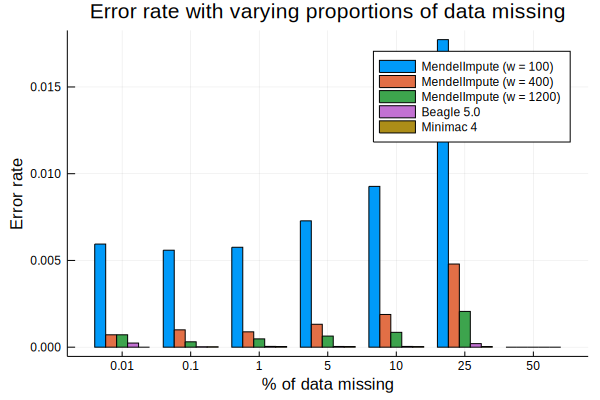

In [44]:
missingprop_name = ["0.01", "0.1", "1", "5", "10", "25", "50"]
groupedbar(missingprop_name, [mendel_100_error mendel_400_error mendel_1200_error beagle5_error minimac4_error],
    label = ["MendelImpute (w = 100)", "MendelImpute (w = 400)", "MendelImpute (w = 1200)", "Beagle 5.0", "Minimac 4"], 
    title = "Error rate with varying proportions of data missing",
    ylabel = "Error rate", xlabel = "% of data missing")

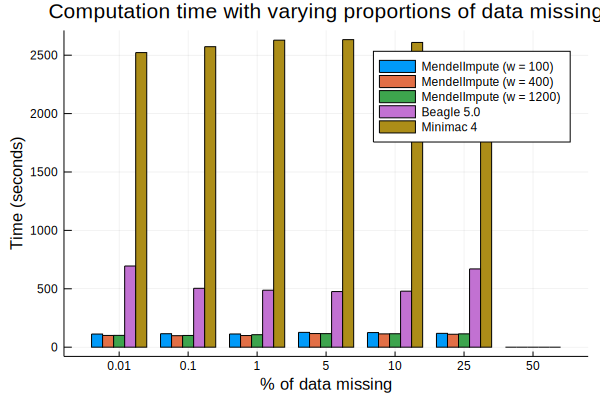

In [42]:
groupedbar(missingprop_name, [mendel_100_times mendel_400_times mendel_1200_times beagle5_times minimac4_times],
    label = ["MendelImpute (w = 100)", "MendelImpute (w = 400)", "MendelImpute (w = 1200)", "Beagle 5.0", "Minimac 4"], 
    title = "Computation time with varying proportions of data missing",
    ylabel = "Time (seconds)", xlabel = "% of data missing")